

> Grace Esther



#**2A. Brain Tumor Classification Dataset Description**

This dataset is used for a multi-class image classification task to detect and classify brain tumors into four categories based on MRI scans. The categories are:

- **Glioma**
- **Meningioma**
- **Pituitary**
- **No Tumor**

### **Dataset Structure**

The dataset is organized into two main directories:

- `Training/`: Contains labeled images used to train the CNN model.
- `Testing/`: Contains labeled images used to evaluate model performance.

Each of these directories is further divided into four subdirectories, one for each class.


### **Image Count Summary**

| Class       | Training Images | Testing Images |
|-------------|------------------|----------------|
| Glioma      | 1321             | 300            |
| Meningioma  | 1339             | 306            |
| No Tumor    | 1595             | 405            |
| Pituitary   | 1457             | 300            |
| **Total**   | **5712**         | **1311**       |




In [1]:
import os
import random
import zipfile
from glob import glob
import pathlib

import numpy as np
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
tf.config.run_functions_eagerly(True)

# **A. Exploratory Data Analysis, Data Splitting, and Pre-processing**

## Load paths & labels

In [3]:
zip_ref = zipfile.ZipFile("/content/Dataset 2A.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
data_dir = pathlib.Path("/content/Training")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['glioma' 'meningioma' 'notumor' 'pituitary']


In [5]:
root_dirs = ["Training", "Testing"]
base_path = "/content"

print("There are 2 directories and 0 images in 'brain_tumor'.")
for root in root_dirs:
    full_root = os.path.join(base_path, root)
    rel_root = f"brain_tumor/{root}"

    for dirpath, dirnames, filenames in os.walk(full_root):
        rel_path = os.path.relpath(dirpath, base_path)
        rel_path = rel_path.replace("Training", "brain_tumor/Training").replace("Testing", "brain_tumor/Testing")
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{rel_path}'.")

There are 2 directories and 0 images in 'brain_tumor'.
There are 4 directories and 0 images in 'brain_tumor/Training'.
There are 0 directories and 1339 images in 'brain_tumor/Training/meningioma'.
There are 0 directories and 1321 images in 'brain_tumor/Training/glioma'.
There are 0 directories and 1595 images in 'brain_tumor/Training/notumor'.
There are 0 directories and 1457 images in 'brain_tumor/Training/pituitary'.
There are 4 directories and 0 images in 'brain_tumor/Testing'.
There are 0 directories and 306 images in 'brain_tumor/Testing/meningioma'.
There are 0 directories and 300 images in 'brain_tumor/Testing/glioma'.
There are 0 directories and 405 images in 'brain_tumor/Testing/notumor'.
There are 0 directories and 300 images in 'brain_tumor/Testing/pituitary'.


In [6]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
train_path = "/content/Training"
test_path = "/content/Testing"

def load_image_paths(folder, class_names):
    paths, labels = [], []
    for label in class_names:
        class_path = os.path.join(folder, label)
        for file in glob(os.path.join(class_path, "*.jpg")):
            paths.append(file)
            labels.append(label)
    return paths, labels

train_paths, train_labels = load_image_paths(train_path, classes)
test_paths, test_labels = load_image_paths(test_path, classes)

## EDA

Color histograms

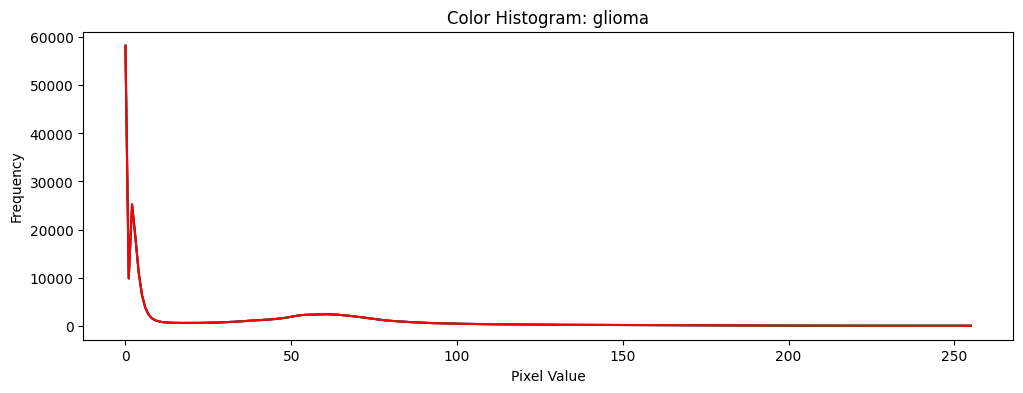

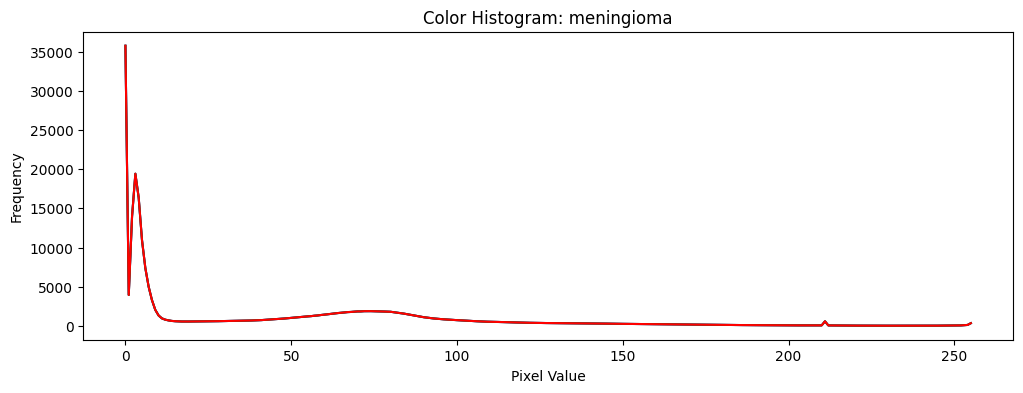

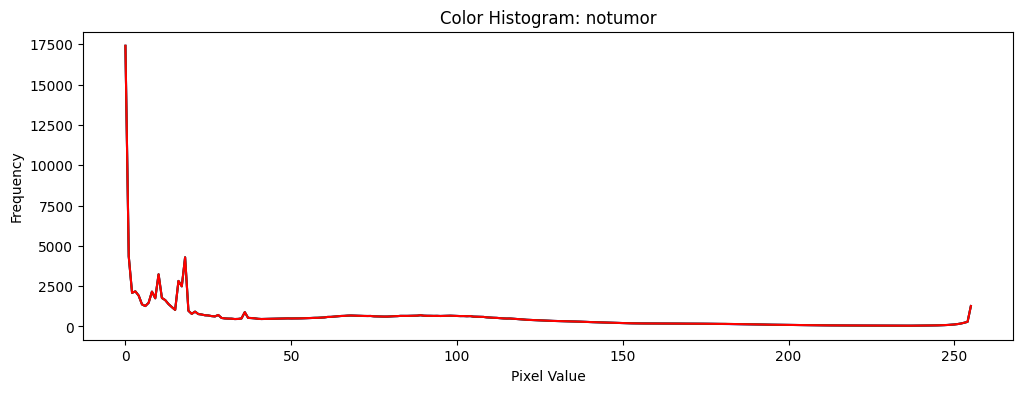

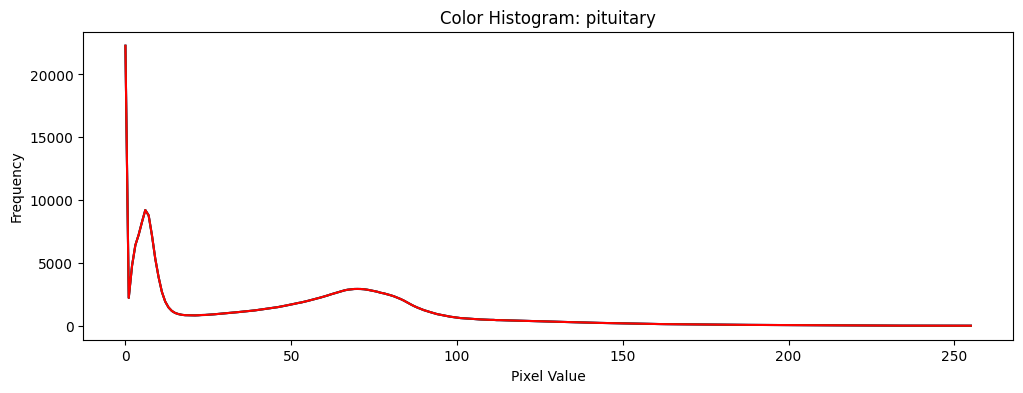

In [7]:
def plot_color_histograms(image_paths, title):
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(12, 4))
    for i, color in enumerate(colors):
        channel_vals = []
        for img_path in image_paths[:100]:
            img = cv2.imread(img_path)
            if img is None: continue
            hist = cv2.calcHist([img], [i], None, [256], [0, 256]).flatten()
            channel_vals.append(hist)
        avg_hist = np.mean(channel_vals, axis=0)
        plt.plot(avg_hist, color=color)
    plt.title(f"Color Histogram: {title}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

for cls in classes:
    cls_imgs = [p for p, l in zip(train_paths, train_labels) if l == cls]
    plot_color_histograms(cls_imgs, cls)

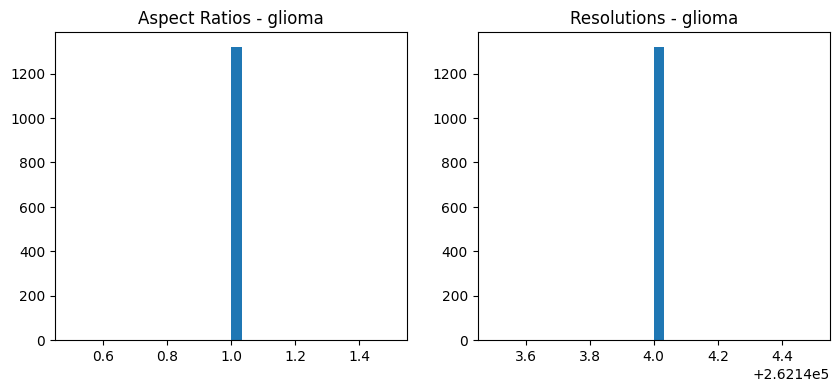

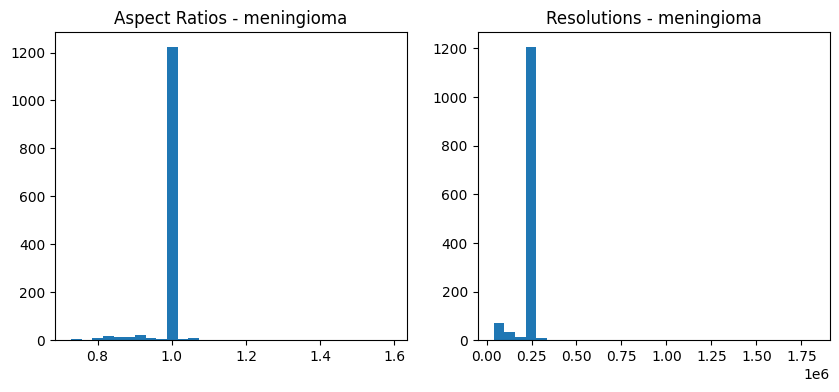

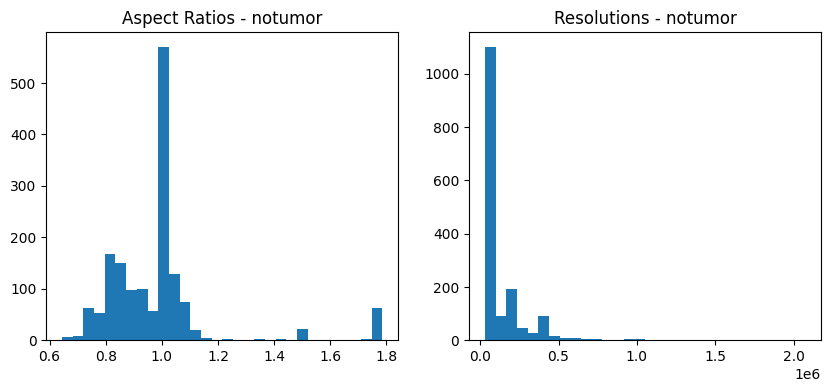

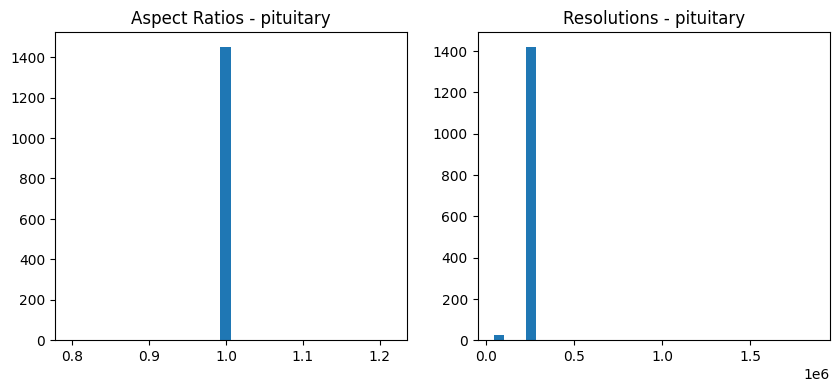

In [8]:
def plot_aspect_resolution(image_paths, label):
    aspect_ratios, resolutions = [], []
    for path in image_paths:
        try:
            img = Image.open(path)
            w, h = img.size
            aspect_ratios.append(w / h)
            resolutions.append(w * h)
        except: continue

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(aspect_ratios, bins=30)
    plt.title(f"Aspect Ratios - {label}")

    plt.subplot(1, 2, 2)
    plt.hist(resolutions, bins=30)
    plt.title(f"Resolutions - {label}")
    plt.show()

for cls in classes:
    cls_imgs = [p for p, l in zip(train_paths, train_labels) if l == cls]
    plot_aspect_resolution(cls_imgs, cls)

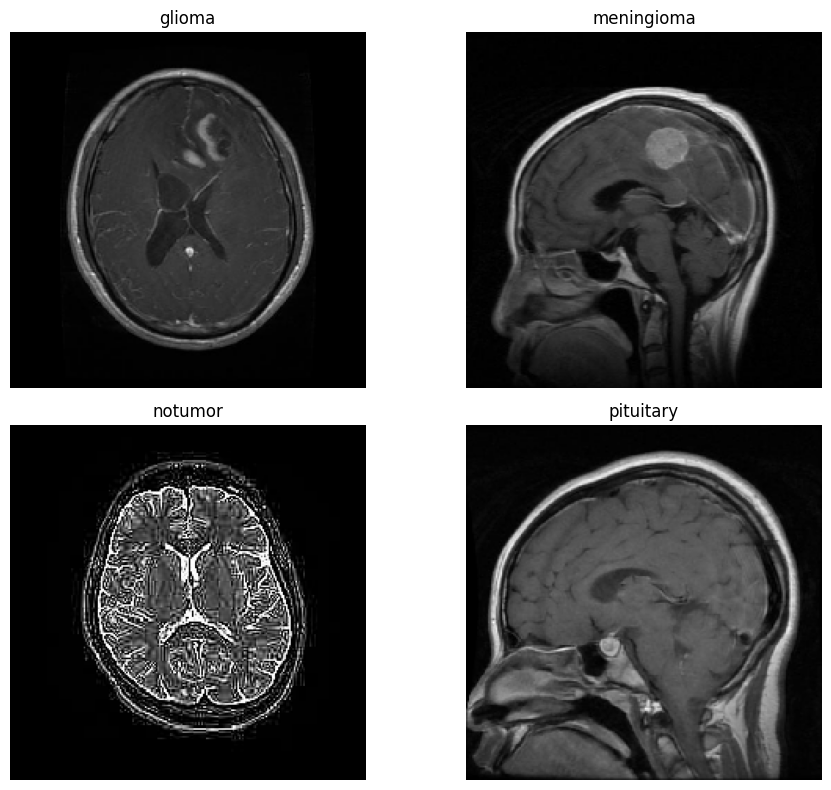

In [9]:
images = ['glioma', 'meningioma', 'notumor', 'pituitary']

fig = plt.figure(figsize=(10, 8))
for i in range(len(images)):
    img_path = os.path.join(train_path, images[i])
    sample_img = os.listdir(img_path)[0]
    ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
    plt.title(images[i])
    plt.axis("off")
    ax.imshow(load_img(os.path.join(img_path, sample_img), target_size=(227, 227)))
plt.tight_layout()
plt.show()

Count number of images per class

In [10]:
image_count = []
class_names = []

print('{:18s}'.format('Class'), end='')
print('Count:')
print('-' * 24)

for folder in sorted(os.listdir(train_path)):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        folder_num = len(os.listdir(folder_path))
        image_count.append(folder_num)
        class_names.append(folder)
        print('{:20s}'.format(folder), folder_num)

print('-' * 24)
print("Number of classes:", len(class_names))

Class             Count:
------------------------
glioma               1321
meningioma           1339
notumor              1595
pituitary            1457
------------------------
Number of classes: 4


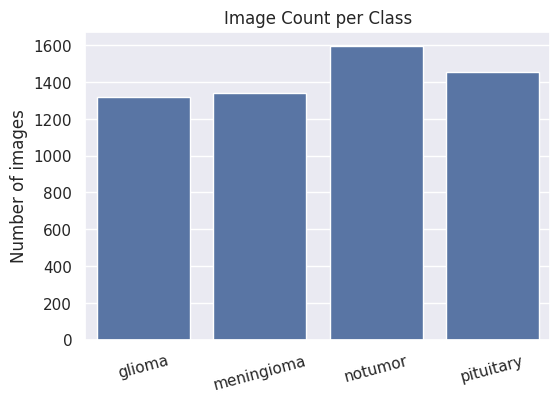

In [11]:
sns.set(rc={'figure.figsize': (6, 4)})
sns.barplot(x=class_names, y=image_count)
plt.ylabel('Number of images')
plt.title('Image Count per Class')
plt.xticks(rotation=15)
plt.show()

In [12]:
# train_paths_final, val_paths, train_labels_final, val_labels = train_test_split(
#     train_paths, train_labels, test_size=0.15, stratify=train_labels, random_state=42)

### **Preprocessing**
- Used `ImageDataGenerator` with normalization and augmentation
- Resized all images to a uniform shape compatible with AlexNet
- Applied label encoding to the target classes

In [13]:
tf.random.set_seed(42)

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/content/Training/"
test_dir = "/content/Testing/"

In [15]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(227, 227),
                                               class_mode="categorical",
                                               shuffle=True,
                                               subset='training',
                                               seed=42)


valid_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(227, 227),
                                               class_mode="categorical",
                                               shuffle=True,
                                               subset='validation',
                                               seed=42)

test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(227, 227),
                                               class_mode="categorical",
                                               shuffle=False,
                                               seed=42)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


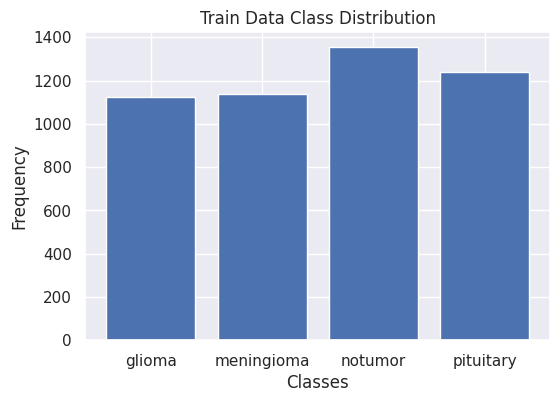

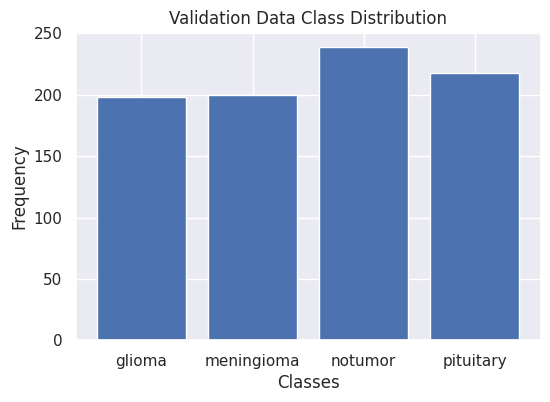

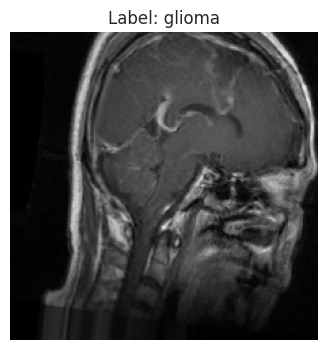

In [16]:
class_indices = train_data.class_indices
class_names = list(class_indices.keys())

def plot_class_distribution(generator, title):
    labels = []
    for i in range(len(generator)):
        _, label_batch = generator[i]
        labels.extend(np.argmax(label_batch, axis=1))

    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique, class_names)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_class_distribution(train_data, "Train Data Class Distribution")
plot_class_distribution(valid_data, "Validation Data Class Distribution")

images, labels = next(train_data)
plt.imshow(images[0])
plt.title(f"Label: {class_names[np.argmax(labels[0])]}")
plt.axis("off")
plt.show()

# **B. Manual AlexNet Model Creation and Baseline Training**

In [17]:
alexnet_model_0 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(227, 227, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Conv2D(384, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [19]:
alexnet_model_0.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

alexnet_model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,297,732 (222.39 MB)

 Trainable params: 58,297,732 (222.39 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_0 = alexnet_model_0.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 86s 534ms/step - accuracy: 0.3202 - loss: 1.3005 - val_accuracy: 0.5754 - val_loss: 1.1036
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 526ms/step - accuracy: 0.5702 - loss: 0.9575 - val_accuracy: 0.6187 - val_loss: 0.9409
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 523ms/step - accuracy: 0.6561 - loss: 0.8103 - val_accuracy: 0.6292 - val_loss: 1.0392
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 520ms/step - accuracy: 0.7021 - loss: 0.7238 - val_accuracy: 0.7263 - val_loss: 0.7505
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 517ms/step - accuracy: 0.7397 - loss: 0.6403 - val_accuracy: 0.7439 - val_loss: 0.7239
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 519ms/step - accuracy: 0.7733 - loss: 0.5621 - val_accuracy: 0.7193 - val_loss: 0.7726
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 515ms/step - accuracy: 0.8034 - loss: 0.4969 - val_accuracy: 0.7462 - val_loss: 0.6897
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 519ms/step - accuracy: 0.8070 - loss: 0.4945 - val

# **C. AlexNet Architecture Modification and Advanced Training**

In [40]:
alexnet_model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation='softmax')
])

In [41]:
alexnet_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

alexnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 187,231,590 (714.23 MB)

 Trainable params: 62,403,484 (238.05 MB)

 Non-trainable params: 21,136 (82.56 KB)

 Optimizer params: 124,806,970 (476.10 MB)

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [43]:
history = alexnet_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
epochs = 10
batch_size = 32
image_height, image_width = 227, 227

In [45]:
# steps_per_epoch = train_data.samples // batch_size
# validation_steps = valid_data.samples // batch_size

In [46]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [47]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(227, 227),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(227, 227),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

nb_train_samples = train_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [48]:
# callbacks_list = [
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1),
#     tf.keras.callbacks.ModelCheckpoint(filepath='alexnet_brain_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
#     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
# ]

In [65]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='brain_tumor_model.h5',
        monitor='val_accuracy', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
]

In [66]:
history_final = alexnet_model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks=callbacks_list,
        validation_data=test_generator,
        verbose=1,
        validation_steps=nb_test_samples // batch_size)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8136 - loss: 0.5139
Epoch 1: val_accuracy improved from -inf to 0.66562, saving model to brain_tumor_model.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 87s 487ms/step - accuracy: 0.8136 - loss: 0.5139 - val_accuracy: 0.6656 - val_loss: 1.7899 - learning_rate: 1.0000e-04
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8003 - loss: 0.5513
Epoch 2: val_accuracy improved from 0.66562 to 0.74219, saving model to brain_tumor_model.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 459ms/step - accuracy: 0.8004 - loss: 0.5512 - val_accuracy: 0.7422 - val_loss: 0.7994 - learning_rate: 1.0000e-04
Epoch 3/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 47s 266ms/step - accuracy: 0.6250 - loss: 0.8398
Epoch 3: val_accuracy did not improve from 0.74219
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6250 - loss: 0.8398 - val_accuracy: 0.7266 - val_loss: 0.8502 - learning_rate: 1.0000e-04
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8096 - loss: 0.5136
Epoch 4: val_accuracy did not improve from 0.74219
178/178 ━━━━━━━━━━━━━━━━━━━━ 103s 408ms/step - accuracy: 0.8097 - loss: 0.5135 - val_accuracy: 0.6578 - val_loss: 1.1664 - learning_rate: 1.0000e-04
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8104 - loss: 0.5287
Epoch 5: val_accuracy improved from 0.74219 to 0.78594, saving model to brain_tumor_model.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 446ms/step - accuracy: 0.8104 - loss: 0.5286 - val_accuracy: 0.7859 - val_loss: 0.6637 - learning_rate: 1.0000e-04
Epoch 6/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1:11 405ms/step - accuracy: 0.8750 - loss: 0.7015
Epoch 6: val_accuracy did not improve from 0.78594
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8750 - loss: 0.7015 - val_accuracy: 0.7625 - val_loss: 0.8937 - learning_rate: 1.0000e-04
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8400 - loss: 0.4468
Epoch 7: val_accuracy did not improve from 0.78594
178/178 ━━━━━━━━━━━━━━━━━━━━ 107s 400ms/step - accuracy: 0.8400 - loss: 0.4469 - val_accuracy: 0.4641 - val_loss: 6.4189 - learning_rate: 1.0000e-04
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8385 - loss: 0.4483
Epoch 8: val_accuracy did not improve from 0.78594
178/178 ━━━━━━━━━━━━━━━━━━━━ 71s 400ms/step - accuracy: 0.8385 - loss: 0.4483 - val_accuracy: 0.5891 - val_loss: 1.8654 - learning_rate: 

# **D. Model Evaluation on Test Data**

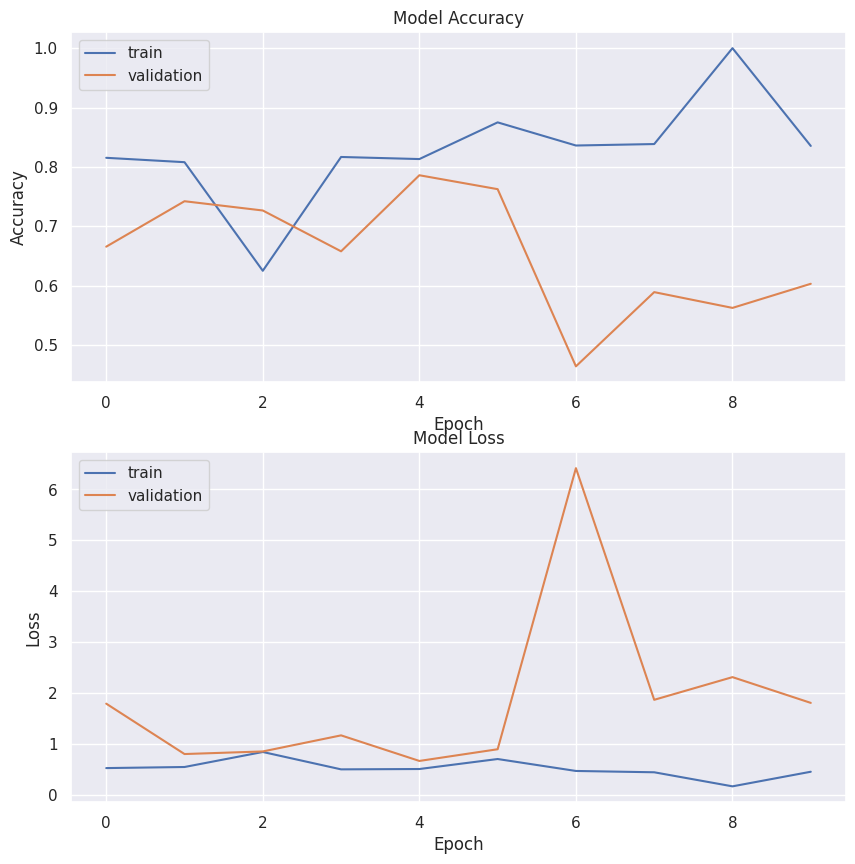

In [67]:
plt.figure(1, figsize = (10, 10))
plt.subplot(211)
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(212)
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [68]:
score = alexnet_model.evaluate(test_generator)
print('test loss:', score[0])
print('test accuracy:', score[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6113 - loss: 1.7841
test loss: 1.824396014213562
test accuracy: 0.5942028760910034


In [69]:
alexnet_model.save("./brain_tumor_model.h5")

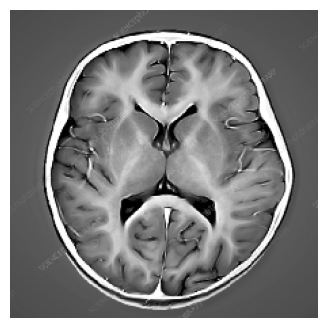

In [35]:
sample_path = '/content/'
img = load_img(sample_path + "brain_sample.png", target_size=(227, 227))
plt.imshow(img)
plt.axis("off")
plt.show()

In [36]:
def load_image(filename):
    img = load_img(filename, color_mode="rgb", target_size=(227, 227))
    img = img_to_array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [37]:
img = load_image(sample_path + "brain_sample.png")
model = load_model('brain_tumor_model.h5')

In [38]:
img = load_image("brain_sample.png")

In [39]:
predict_x = model.predict(img)
result = np.argmax(predict_x, axis=1)

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

if result[0] < len(class_labels):
    print(f"Predicted class: {class_labels[result[0]]}")
else:
    print("Class not recognized.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Predicted class: notumor


# **E. Link**

# **Conclusion**

## Baseline Model: AlexNet

### Model Info
- **Total parameters**: 58,297,732
- **Trainable parameters**: 58,297,732

### Training Results (10 Epochs)
| Epoch | Train Accuracy | Train Loss | Val Accuracy | Val Loss |
|-------|----------------|------------|--------------|----------|
| 1     | 0.3202         | 1.3005     | 0.5754       | 1.1036   |
| 5     | 0.7397         | 0.6403     | 0.7439       | 0.7239   |
| 10    | 0.8350         | 0.4371     | 0.7708       | 0.6091   |

---

## Advanced Model: Modified AlexNet

### Model Info
- **Total parameters**: 187,231,590
- **Trainable parameters**: 62,403,484
- **Optimizer parameters**: 124,806,970

### Improvements
- Used `ModelCheckpoint` to save best model
- Adam optimizer with low learning rate
- Added regularization techniques

### raining Results (10 Epochs)
| Epoch | Train Accuracy | Train Loss | Val Accuracy | Val Loss |
|-------|----------------|------------|--------------|----------|
| 1     | 0.8136         | 0.5139     | 0.6656       | 1.7899   |
| 5     | 0.8104         | 0.5286     | 0.7859       | 0.6637   |
| 10    | 0.8384         | 0.4260     | 0.6031       | 1.8048   |

---

## Test Results

```
score = model.evaluate(test_generator)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

```
```
Test Loss: 1.8244
Test Accuracy: 0.5942
```
## Example Predicition
```
Predicted class: notumor
Correct class: notumor
```

# Thus,

- Baseline AlexNet showed decent performance and stability with a final validation accuracy of 77.08%.

- Modified AlexNet achieved 78.59% validation accuracy at its best epoch but struggled with overfitting on later epochs.

- Final test accuracy on unseen data was 59.42%, suggesting room for generalization improvement.